# Target Analysis

1. Анализ целевой переменной (максимум 1 балл)

[0.5] Численный анализ:
- Для регрессии:
    - распределение таргета,
    - поиск аномальных значений

[0.5] Визуализация статистик:
- Изолированный анализ
- Анализ во временном контексте



# Выводы

Целевая переменная распределена в диапазоне от 25 до 4999. Значение 99-го перцентиля стабильно остается около 3850 в течение месяцев, что позволяет предположить, что значения выше 4000 можно считать аномальными.

Среднее значение целевой переменной составляет примерно 1100, медианное значение и стандартное отклонение совпадают и равны 850.

В целом, распределение переменной остается стабильным во времени. Единственное значительное изменение наблюдалось в 2020 году, когда распределение заметно сместилось влево, а средние значения и другие статистики снизились на 10,5%.

Распределение скошено вправо, что указывает на наличие небольшого количества полисов с очень большими значениями целевой переменной. Мода равна 25, что свидетельствует о значительном количестве полисов (~60 тысяч) с минимальной выплатой. Это значение стабильно остается самым популярным на протяжении всего наблюдаемого периода.


Значительная доля выплат (38%) сосредоточена в диапазоне от 400 до 1000.


In [1]:
import pandas as pd
import plotly.express as px

from src.config import PROCESSED_DATA_DIR, FIGURES_DIR
from src.plots import save_chart

vs = {"width": 1200, "height": 700, "scale": 3, "renderer": "png"}

2024-12-08 22:15:37.394 | INFO     | src.config:<module>:12 - PROJ_ROOT path is: /Users/vktrbr/Projects/personal/auto_ml_itmo_insurance_regression


In [2]:
data = pd.read_feather(PROCESSED_DATA_DIR / 'train.feather')

In [3]:
data.head()

,ID,AGE,GENDER,ANNUAL_INCOME,MARITAL_STATUS,NUMBER_OF_DEPENDENTS,EDUCATION_LEVEL,OCCUPATION,HEALTH_SCORE,LOCATION,...,PREVIOUS_CLAIMS,VEHICLE_AGE,CREDIT_SCORE,INSURANCE_DURATION,POLICY_START_DATE,CUSTOMER_FEEDBACK,SMOKING_STATUS,EXERCISE_FREQUENCY,PROPERTY_TYPE,PREMIUM_AMOUNT
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,None,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,None,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
stats = data['PREMIUM_AMOUNT'].describe().round(2)
stats

count    1200000.00
mean        1102.54
std          865.00
min           20.00
25%          514.00
50%          872.00
75%         1509.00
max         4999.00
Name: PREMIUM_AMOUNT, dtype: float64

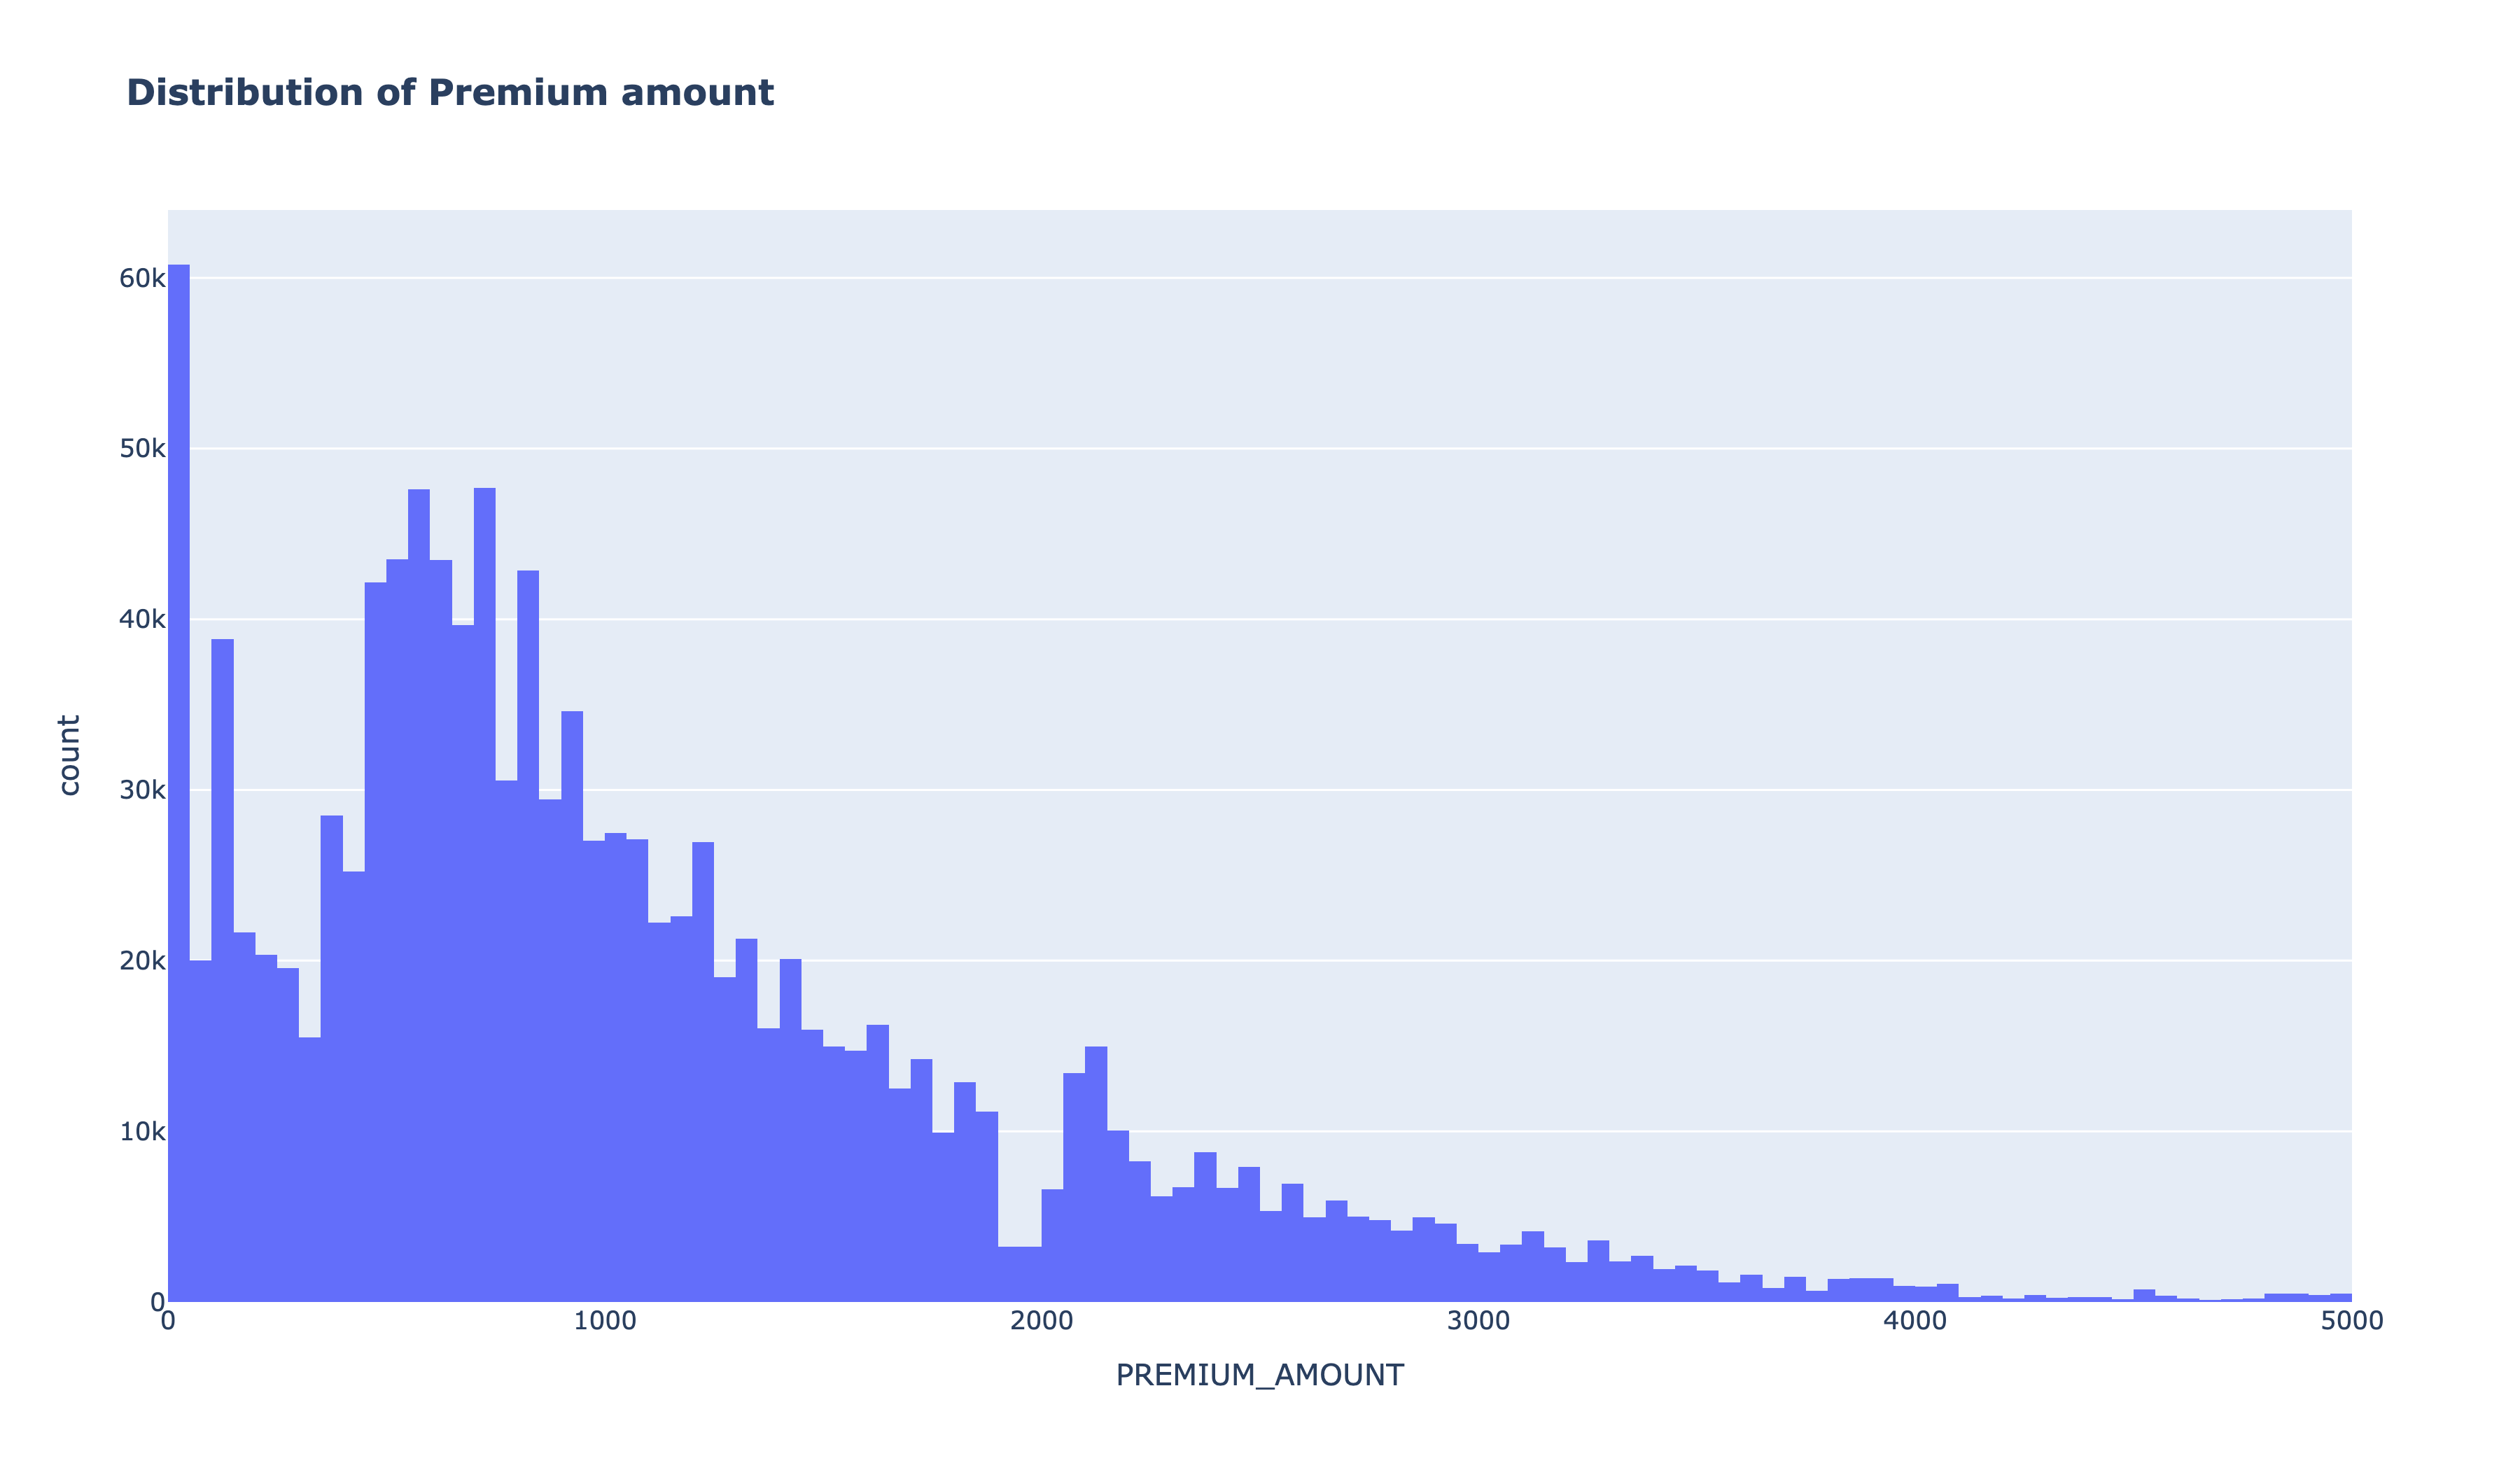

In [5]:
fig_distribution = px.histogram(
    data_frame=data,
    x='PREMIUM_AMOUNT',
    nbins=100,
    title='<b>Distribution of Premium amount'
)

fig_distribution.show(**vs)

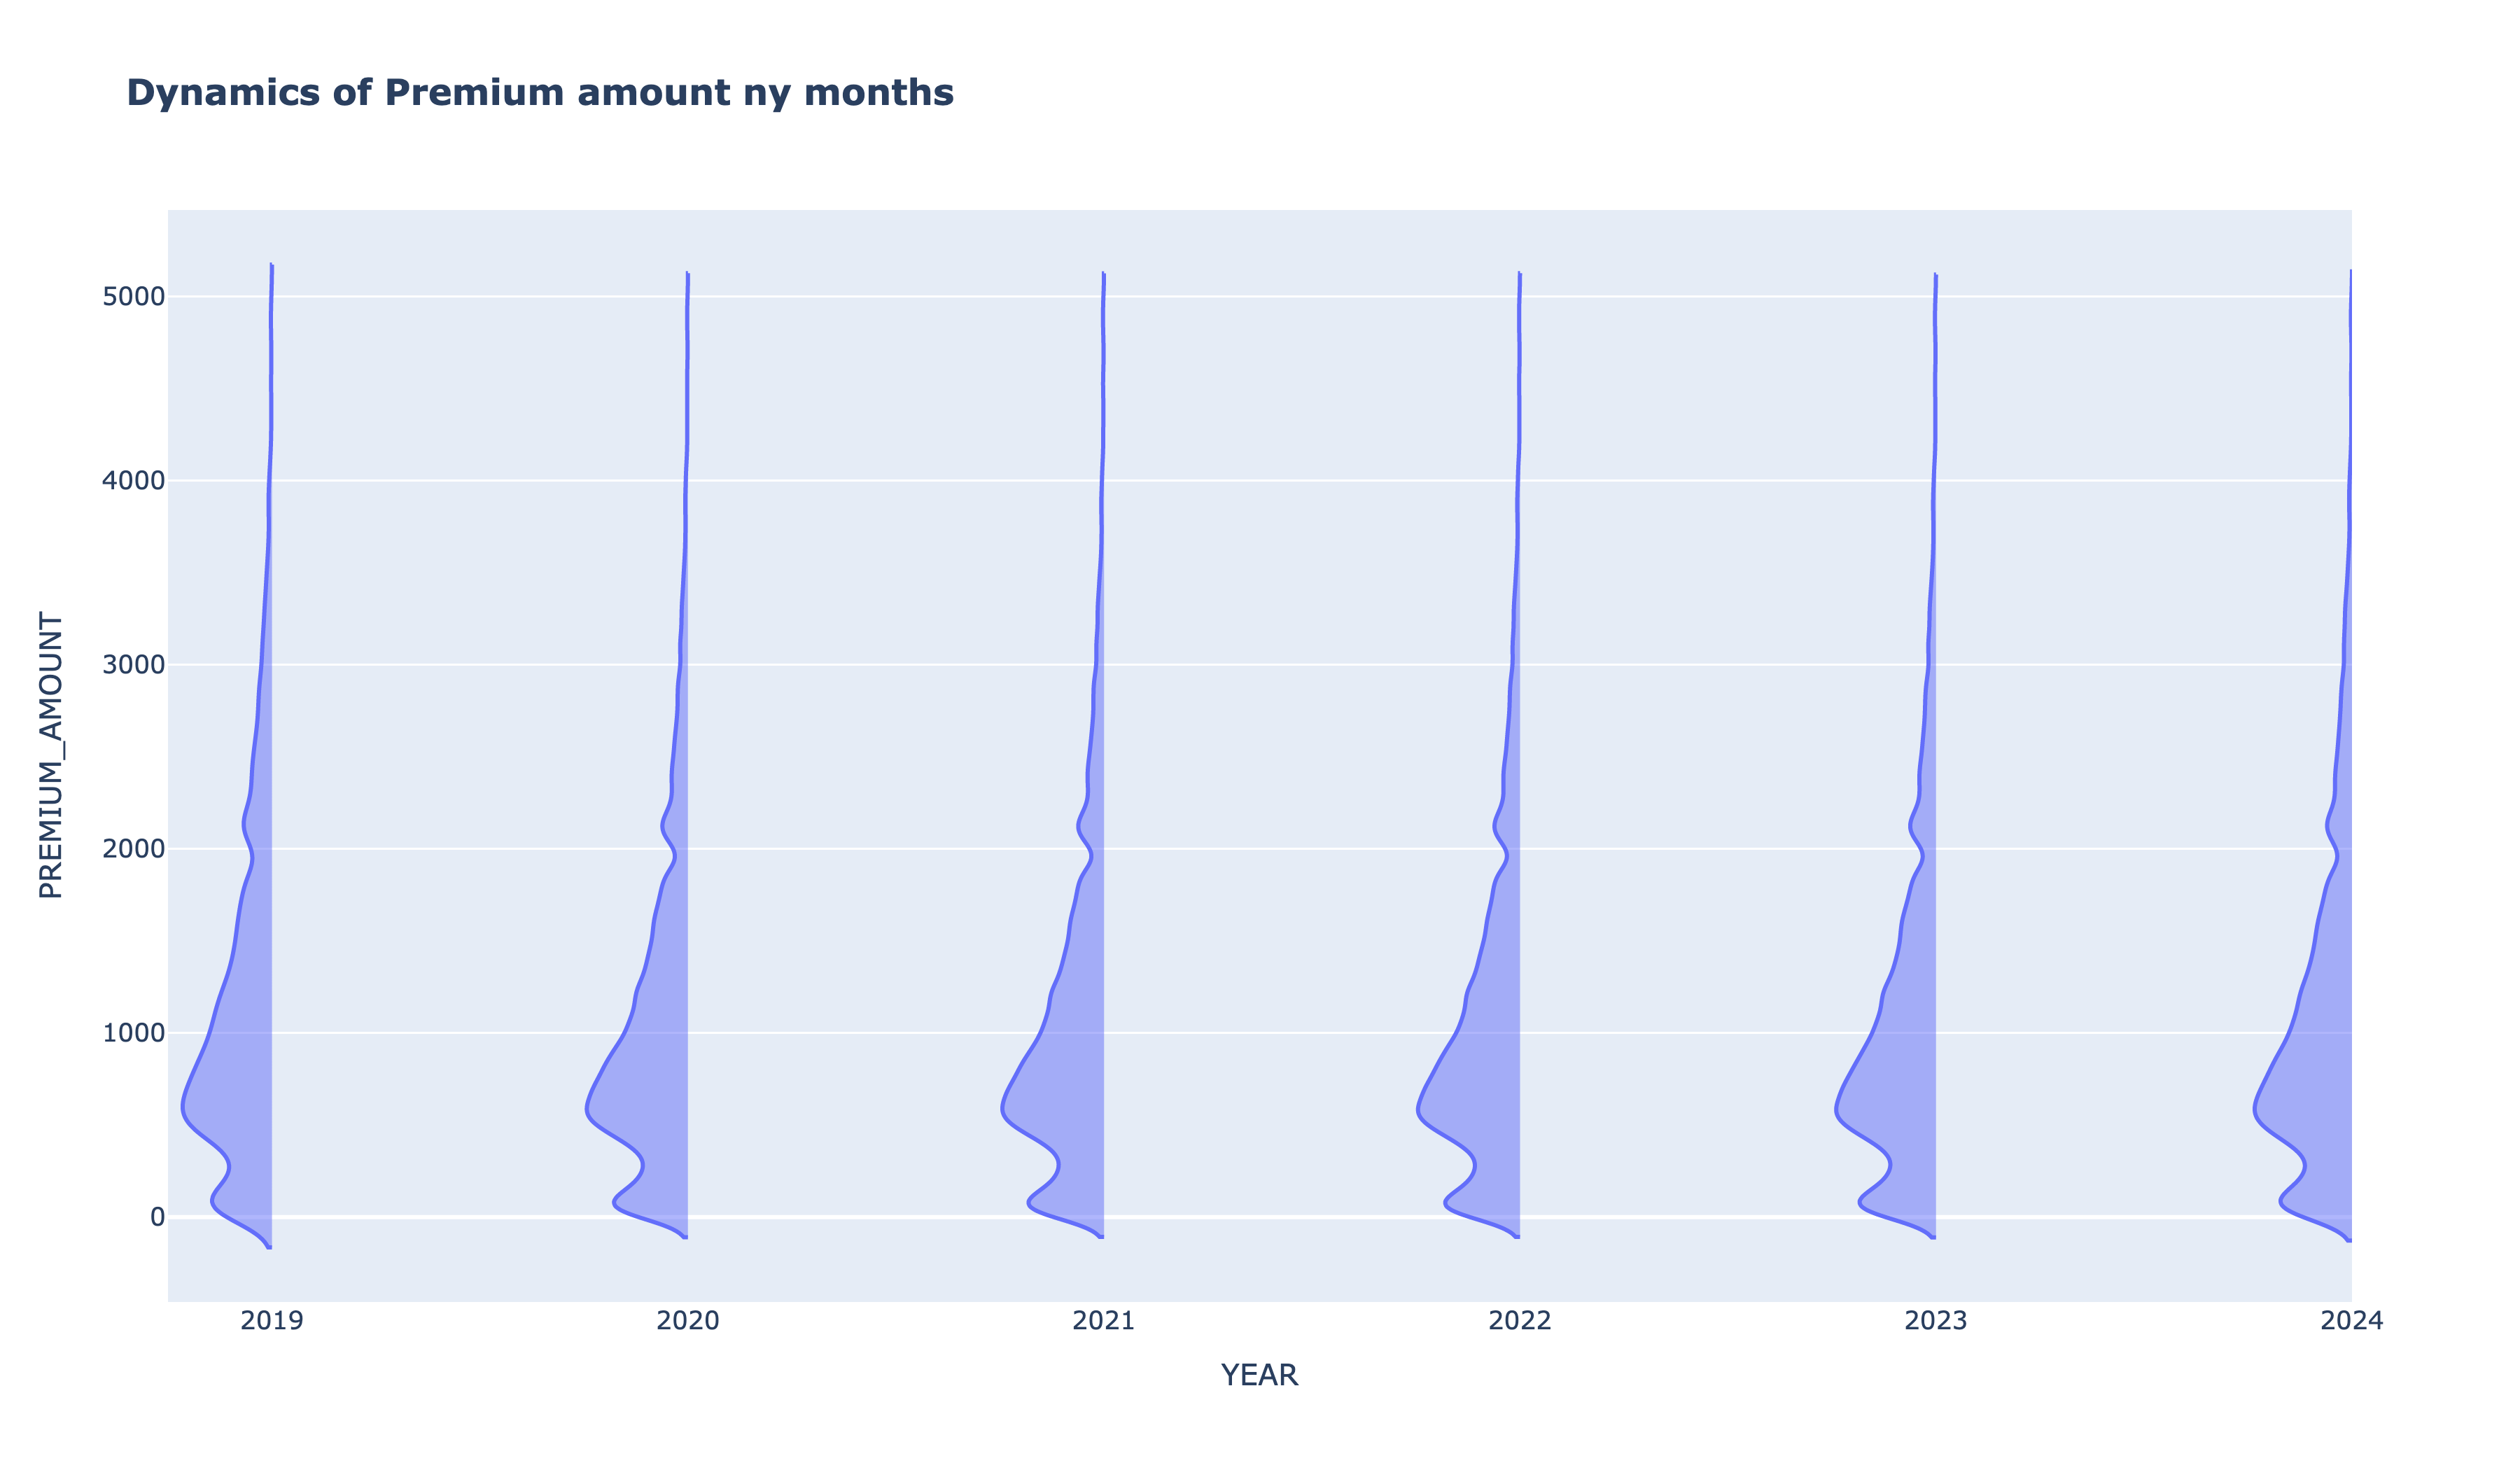

In [6]:
data["YEAR"] = pd.to_datetime(data["POLICY_START_DATE"]).dt.to_period('Y').astype(str)
data = data.sort_values(by='YEAR')

fig_distribution_by_years = px.violin(
    data_frame=data,
    x='YEAR',
    y='PREMIUM_AMOUNT',
    title="<b>Dynamics of Premium amount ny months"
)

fig_distribution_by_years.update_traces(side='negative', points=False)
fig_distribution_by_years.show(**vs)

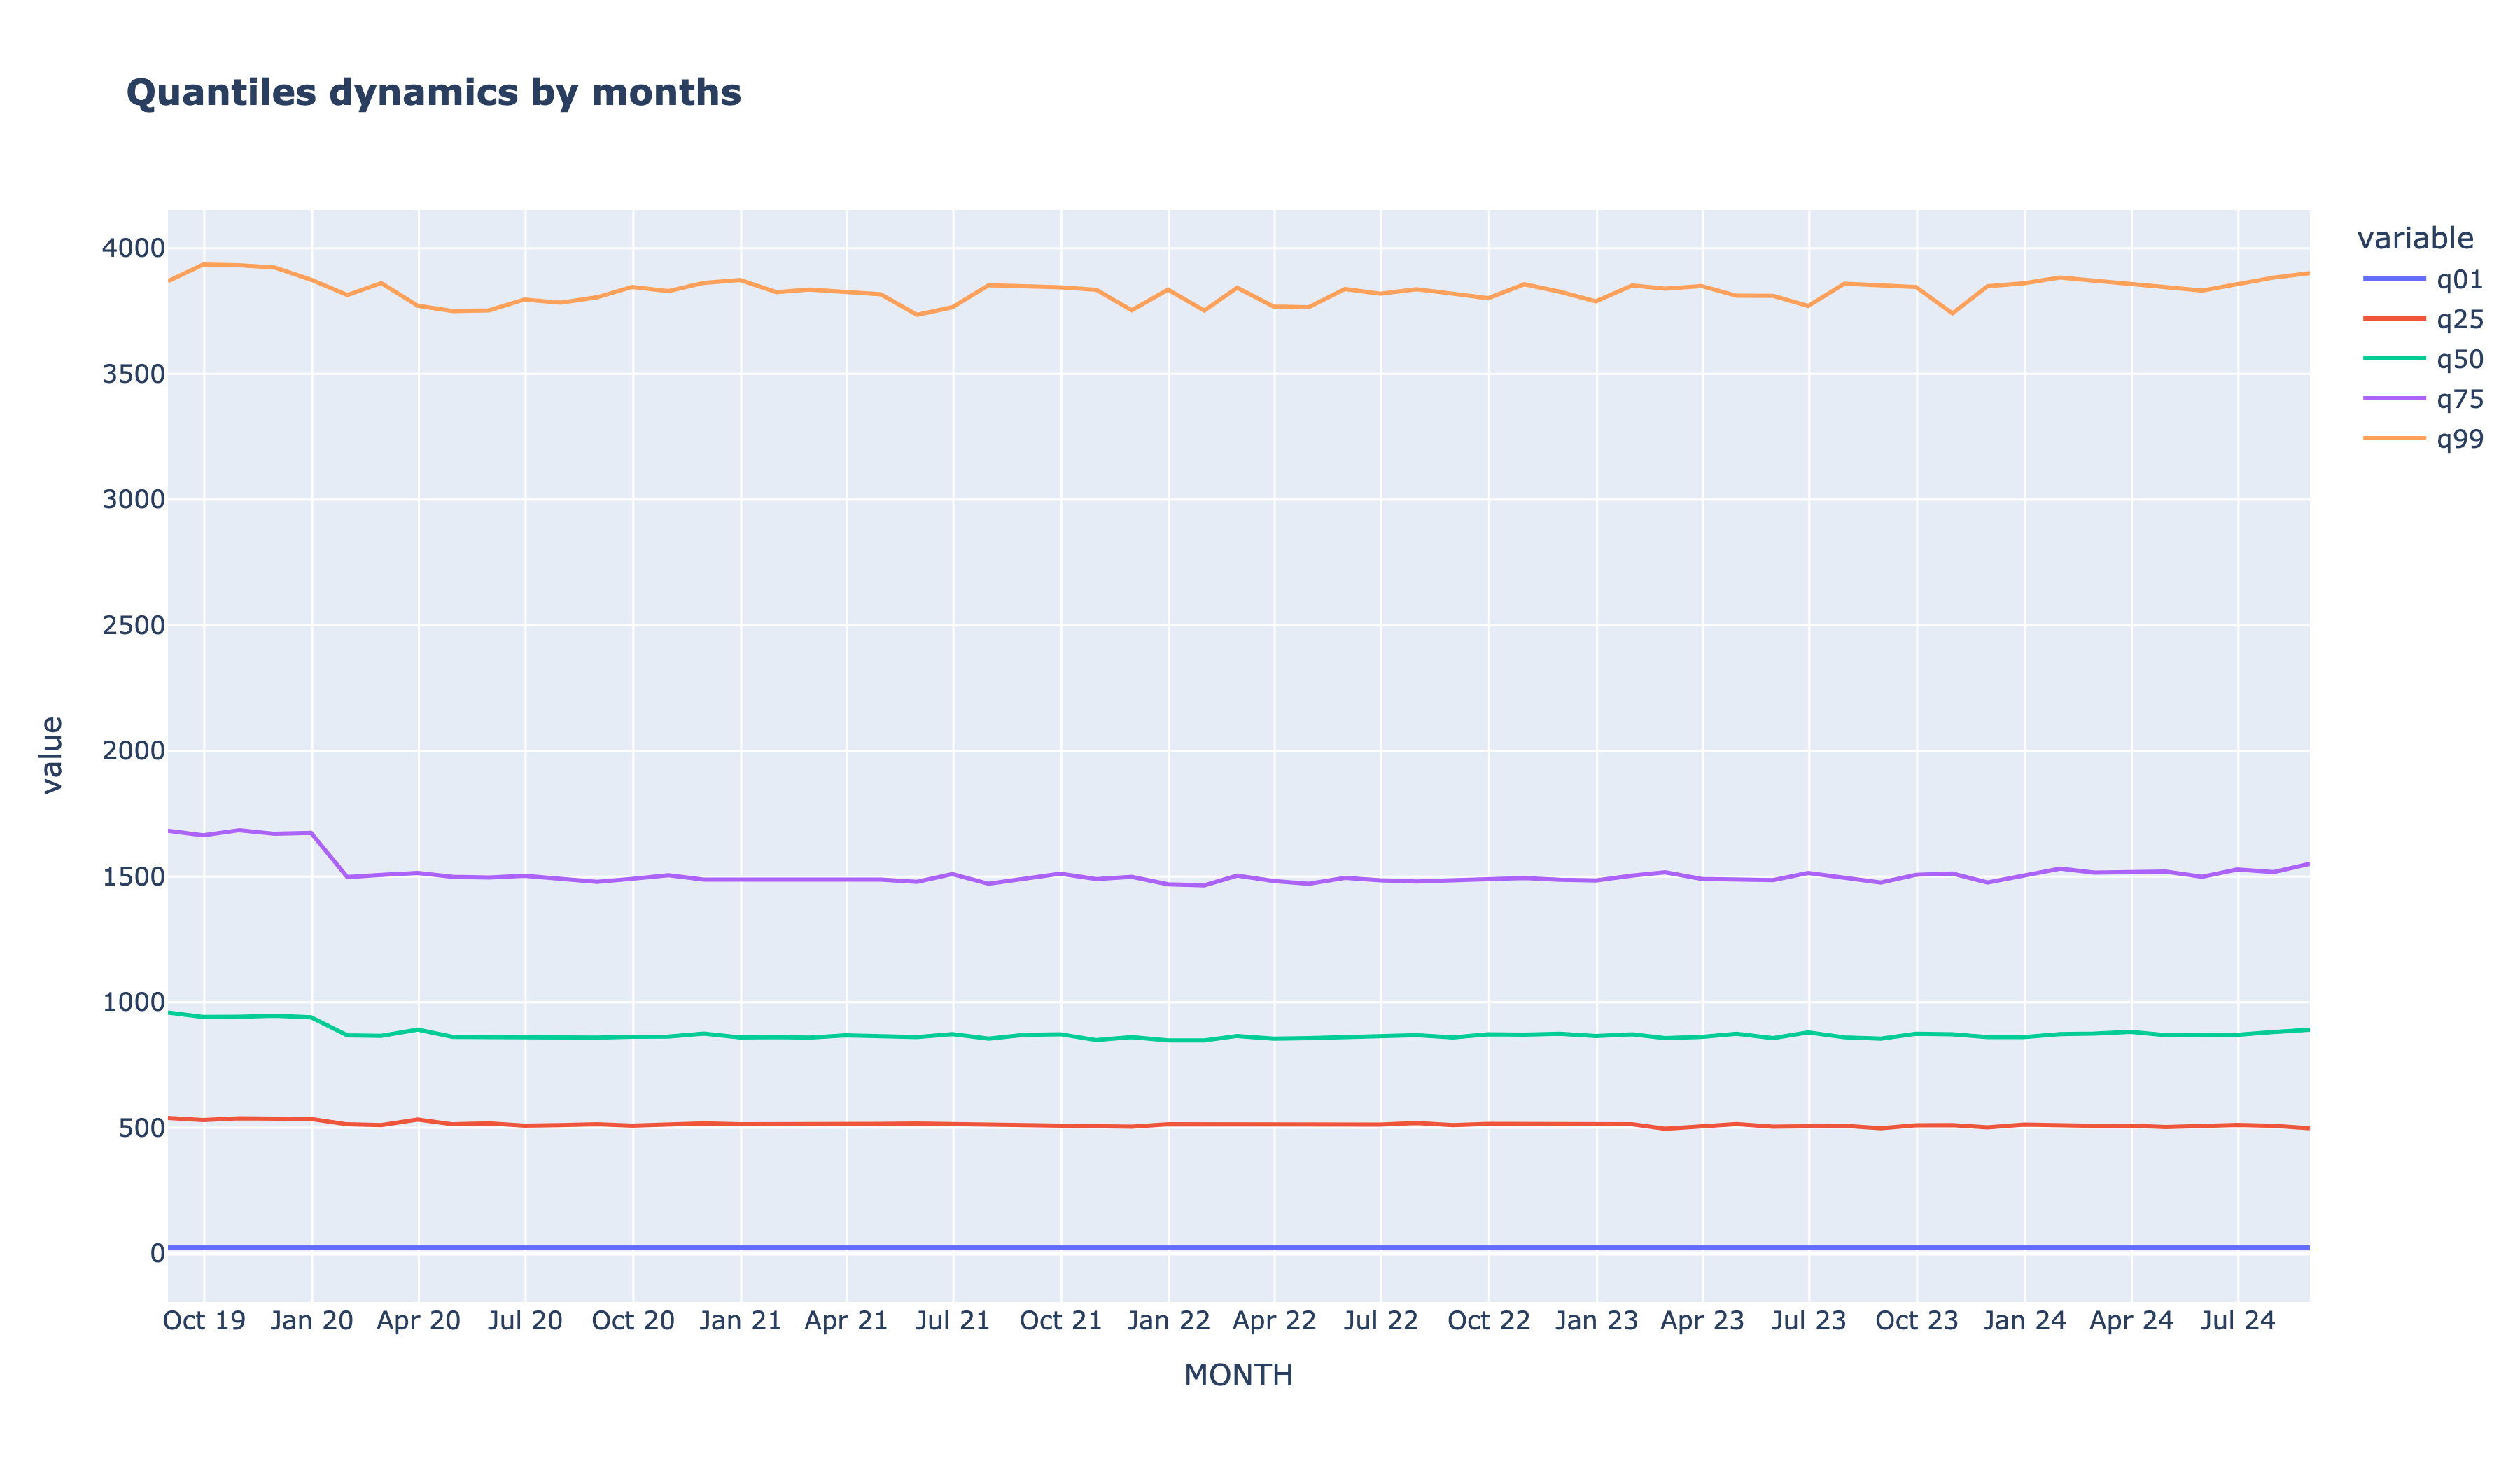

In [7]:
data['MONTH'] = pd.to_datetime(data["POLICY_START_DATE"]).dt.to_period('M')
data['MONTH'] = data['MONTH'].dt.strftime('%Y-%m-%d')

quantiles_by_month = data.groupby('MONTH')['PREMIUM_AMOUNT']
quantiles_by_month = quantiles_by_month.quantile([0.01, 0.25, 0.5, 0.75, 0.99])
quantiles_by_month = quantiles_by_month.unstack().reset_index()
quantiles_by_month.columns = ['MONTH', "q01", "q25", "q50", "q75", "q99"]

fig_quantiles_by_month = px.line(
    data_frame=quantiles_by_month,
    x='MONTH',
    y=["q01", "q25", "q50", "q75", "q99"],
    title="<b>Quantiles dynamics by months"
)

month_xaxis = {"nticks": 30, "tickformat": '%b %y'}
fig_quantiles_by_month.update_xaxes(**month_xaxis)

fig_quantiles_by_month.show(**vs)

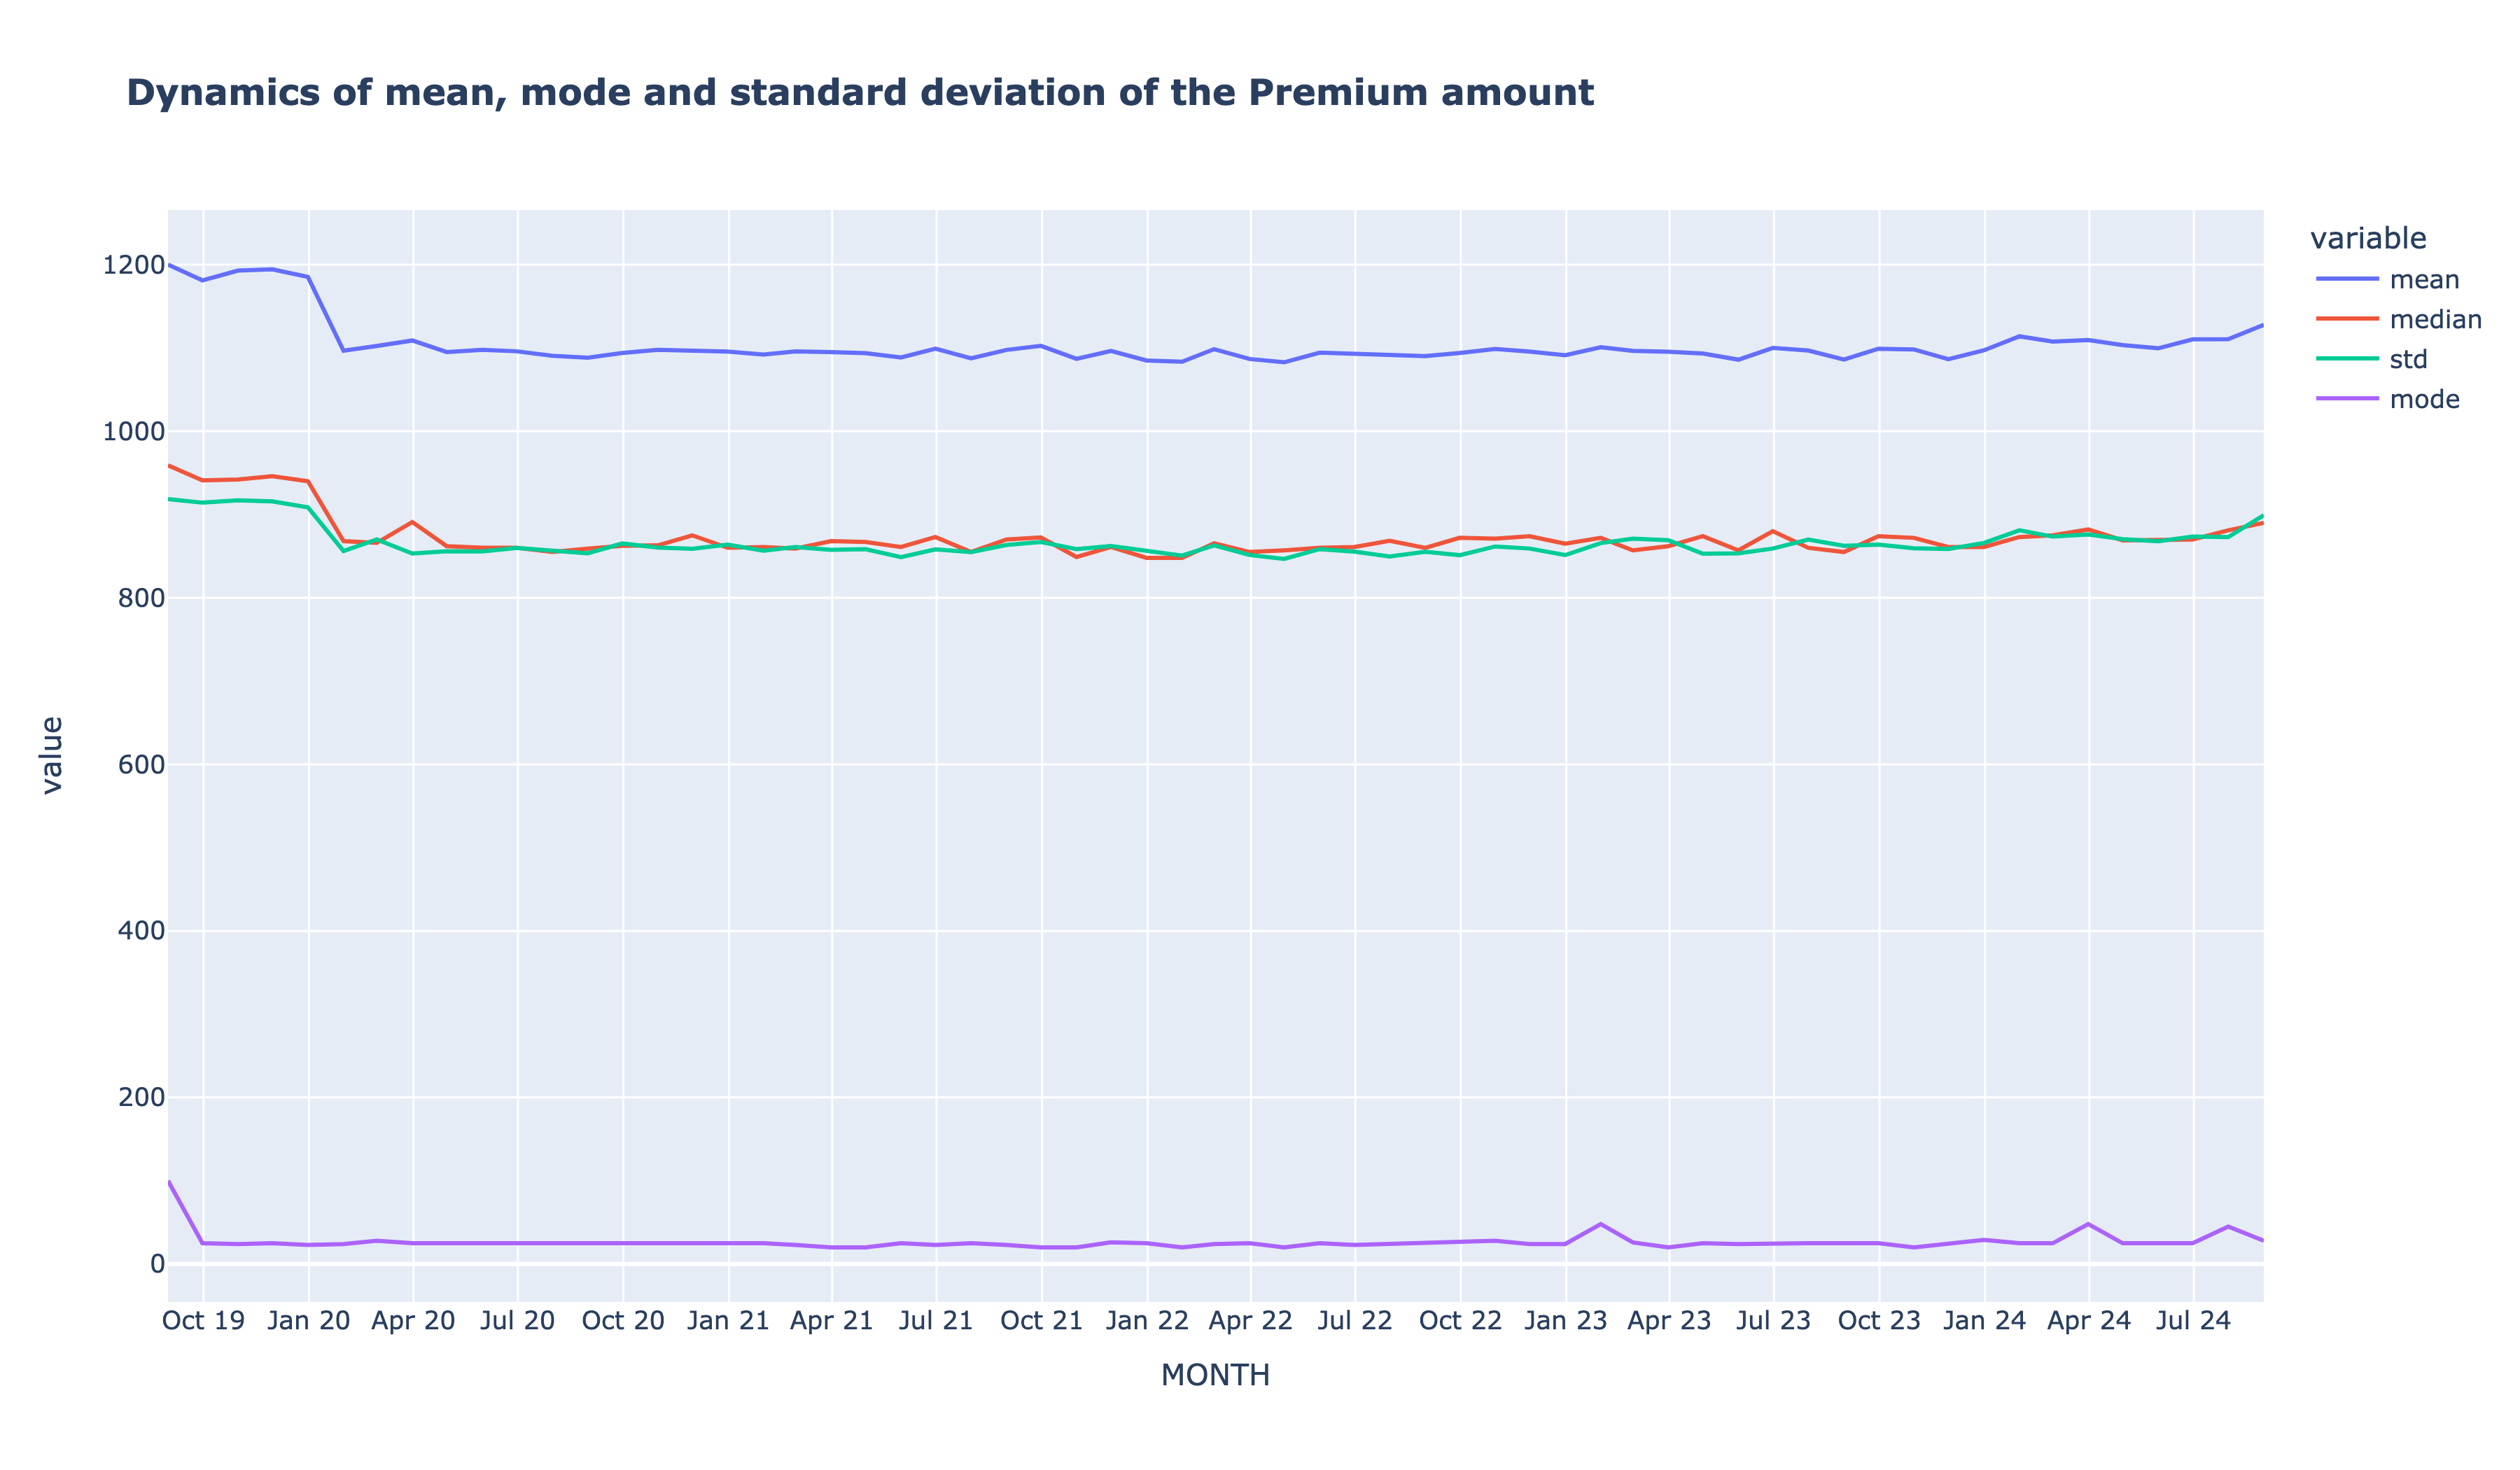

In [8]:
stats_by_month = data.groupby('MONTH')['PREMIUM_AMOUNT'].agg(
    mean='mean',
    median='median',
    std='std',
    mode=lambda x: pd.Series.mode(x)[0],
)

stats_by_month = stats_by_month.reset_index()

fig_stats_by_month = px.line(
    data_frame=stats_by_month,
    x='MONTH',
    y=['mean', 'median', 'std', 'mode'],
    title='<b>Dynamics of mean, mode and standard deviation of the Premium amount',
)
fig_stats_by_month.update_xaxes(**month_xaxis)

fig_stats_by_month.show(**vs)

In [9]:
charts_x_names = [
    (fig_distribution, 'PREMIUM_AMOUNT_DISTRIBUTION'),
    (fig_distribution_by_years, 'PREMIUM_AMOUNT_DISTRIBUTION_BY_YEARS'),
    (fig_quantiles_by_month, 'PREMIUM_AMOUNT_QUANTILES_BY_MONTH'),
    (fig_stats_by_month, 'PREMIUM_AMOUNT_STATS_BY_MONTH'),
]
for chart, name in charts_x_names:
    save_chart(chart, name, FIGURES_DIR / 'target_analysis', vs)

In [10]:
# P between 400 and 1000
data[(data['PREMIUM_AMOUNT'] >= 400) & (data['PREMIUM_AMOUNT'] <= 1000)].shape[0] / data.shape[0]

0.37832916666666666